In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from tensorflow.keras.backend import clear_session
import gc

In [3]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [4]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "support_right", "support_left"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [5]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [6]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [7]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [9]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [10]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))
"""
y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))\ny_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))\n\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [31]:
logdir = "logs/Frequency/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [32]:
%load_ext tensorboard
%tensorboard --logdir logs

In [12]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [13]:
model = Model(inputs=input_layer, outputs=output_layer)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [16]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_frequency,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - R2Score: 0.6166 - loss: 0.3572 - val_R2Score: 0.9024 - val_loss: 0.1032
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.8884 - loss: 0.1085 - val_R2Score: 0.9231 - val_loss: 0.0813
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9053 - loss: 0.0943 - val_R2Score: 0.9466 - val_loss: 0.0564
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9209 - loss: 0.0787 - val_R2Score: 0.9484 - val_loss: 0.0545
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9270 - loss: 0.0718 - val_R2Score: 0.9556 - val_loss: 0.0469
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - R2Score: 0.9347 - loss: 0.0637 - val_R2Score: 0.9553 - val_loss: 0.0473
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9456 - loss: 0.0521 - val_R2Score: 0.9662 - val_loss: 0.0357
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9493 - loss: 0.0481 - val_R2Score: 0.9650 - 

In [17]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_frequency)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.9922 - loss: 0.0070
Test accuracy: 0.9885931015014648


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,421 (861.02 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,948 (574.02 KB)

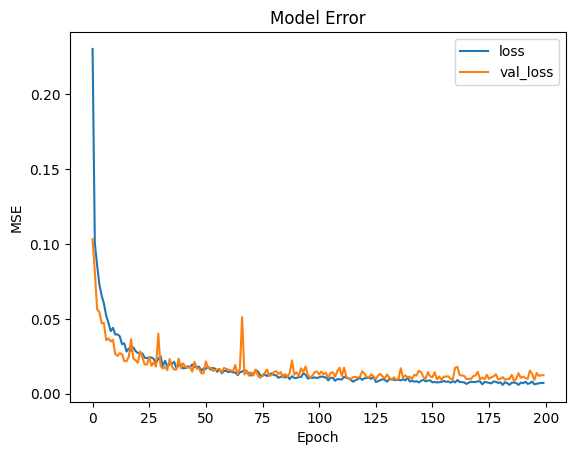

In [19]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()
plt.title("Model Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [20]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_frequency.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [21]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:
               0
0       7.231930
1       3.930802
2      15.363997
3       4.689487
4      21.473736
...          ...
2453  126.832443
2454    2.095607
2455    6.445679
2456   28.430365
2457    0.848992

[2458 rows x 1 columns]


In [22]:
y_test["frequency"]

524        8.5656
4546       3.9866
6971      16.0461
10243      4.3495
7978      21.6986
           ...   
8768     129.0407
9224       2.2995
10168      6.5121
8959      28.7380
3188       1.0268
Name: frequency, Length: 2458, dtype: float64

In [23]:
true= y_test["frequency"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

5.643437348864995

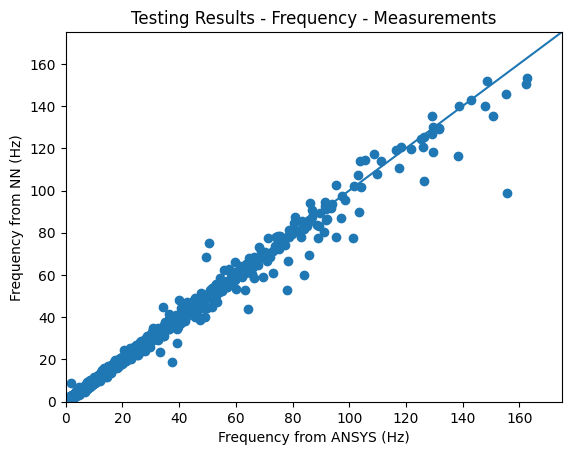

In [27]:
pred=predictions_df
ansys=y_test["frequency"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 175],[0, 175])
plt.xlim(0,175)
plt.ylim(0,175)
plt.xlabel("Frequency from ANSYS (Hz)")
plt.ylabel("Frequency from NN (Hz)")
plt.title("Testing Results - Frequency - Measurements")
plt.show()

In [25]:
clear_session()
del model
gc.collect()

0

In [26]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data:  2.1 MiB
                             x:  1.6 MiB
                       x_train:  1.4 MiB
           x_train_transformed:  1.1 MiB
                             y: 480.2 KiB
                       y_train: 460.9 KiB
                        x_test: 356.6 KiB
            x_test_transformed: 269.0 KiB
                        y_test: 115.2 KiB
 y_train_transformed_frequency: 76.9 KiB
